<a href="https://colab.research.google.com/github/ChicagoPark/chicago_work/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Necessary Modules
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.preprocessing.image import ImageDataGenerator # Data Augmentation(Image transformations) 을 하기 위해 필요한 모듈

import scipy
import keras
from tensorflow.keras.utils import plot_model

In [ ]:
'''
# data path
! gdown --id 1byD-TlXFXVJysi7q3K8y-W_96qbbfF5L
'''

Downloading...
From: https://drive.google.com/uc?id=1byD-TlXFXVJysi7q3K8y-W_96qbbfF5L
To: /content/__ ___.zip
100% 462M/462M [00:02<00:00, 191MB/s]


In [ ]:
#cd drive/MyDrive/Colab\ Notebooks/빅데이터및AI/실차 데이터.zip (Unzipped Files)
#cd drive/MyDrive/Colab\ Notebooks/빅데이터및AI/data.zip (Unzipped Files)/data
# 실차데이터 ! gdown --id 1byD-TlXFXVJysi7q3K8y-W_96qbbfF5L

Downloading...
From: https://drive.google.com/uc?id=1byD-TlXFXVJysi7q3K8y-W_96qbbfF5L
To: /content/__ ___.zip
100% 462M/462M [00:02<00:00, 176MB/s]


In [ ]:
'''data
! zip -FFv data.zip --out data_.zip
! unzip data_.zip -d data
'''
#! unzip 실차데이터.zip -d 실차데이터

'data\n! zip -FFv data.zip --out data_.zip\n! unzip data_.zip -d data\n'

In [ ]:
# 1. 기본 뿌리 디렉터리와 검증데이터 경로를 가져온다
base_path = os.path.abspath('/content/drive/MyDrive/Colab Notebooks/빅데이터및AI/data.zip (Unzipped Files)/data')
print(base_path)

# 2. 데이터 경로를 지정을 해준다.
no_pothole_dir = os.path.join(base_path, '0. stone')
pothole_dir = os.path.join(base_path, '1. pothole')
filled_dir = os.path.join(base_path, '2. filled')

# 3. 데이터 셋의 개수를 카운팅한다.
num_no_pothole = len(os.listdir(no_pothole_dir))
num_pothole_dir = len(os.listdir(pothole_dir))
num_filled_dir = len(os.listdir(filled_dir))

total_data = num_no_pothole + num_pothole_dir + num_filled_dir

print(f'정상도로 : {num_no_pothole} 개 , 팟홀도로 : {num_pothole_dir}, 보수도로 : {num_filled_dir}')

print(f'Total Data 개수 : {total_data}')

/content/drive/MyDrive/Colab Notebooks/빅데이터및AI/data.zip (Unzipped Files)/data
정상도로 : 8912 개 , 팟홀도로 : 5770, 보수도로 : 6875
Total Data 개수 : 21557


In [ ]:
# Train set 과 Validation set 을 나누며, Data Augmentation 작업 또한 추가시킨다.
#11/12 여기 배치 정규화 추가하는 코드 찾으면 넣자
train_image_generator = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.15)
validation_image_generator = ImageDataGenerator(rescale=1./255,
                                                validation_split=0.15)
batch_size = 8
epochs = 15
IMG_HEIGHT = 320
IMG_WIDTH = 320

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=base_path,
                                                           seed = 42,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           subset='training',
                                                           class_mode='sparse')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=base_path,
                                                           seed = 42,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           subset='validation',
                                                           class_mode='sparse')
train_num = train_data_gen.samples # training set 이 몇개인지
val_num = val_data_gen.samples   # validation set 이 몇개인지

Found 18325 images belonging to 3 classes.
Found 3232 images belonging to 3 classes.


# Model Loading

In [ ]:
# Create base model
# input_tensor 는 내가 쓰고 싶은 입력크기
# input_shape 는 모델이 가지는 입력크기를 말하는듯

base_model = tf.keras.applications.Xception(
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        input_shape=None,)

# 해당 층의 매개변수는 그대로 사용하기 위해서 freezing 을 한다.
base_model.trainable = False

83697664/83683744 [==============================] - 1s 0us/step


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 320, 320, 3)]     0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                             

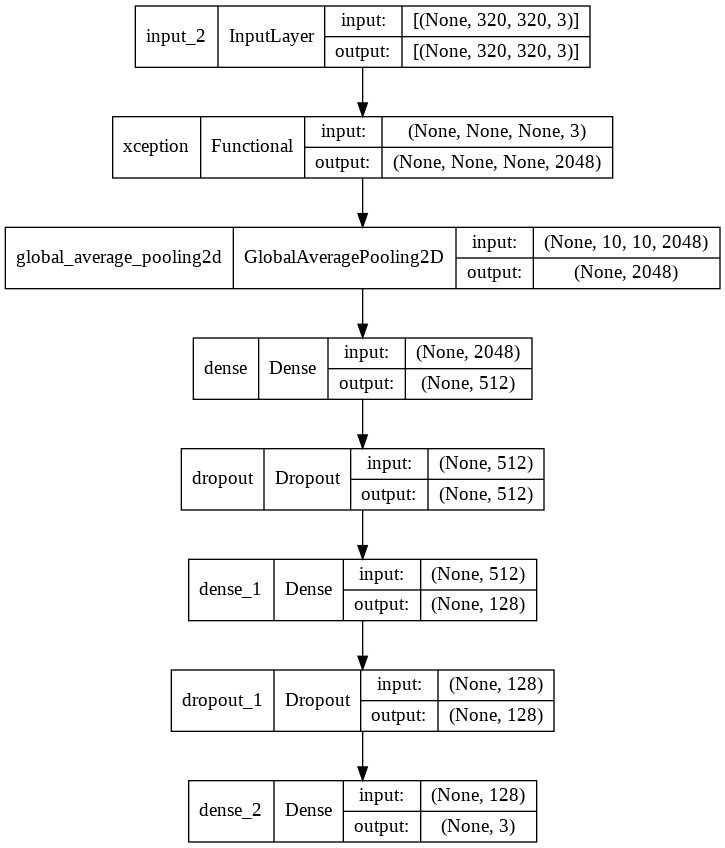

In [ ]:
inputs = keras.Input(shape=(320, 320, 3))
x = base_model(inputs, training=False)
#x = keras.layers.Dropout(0.2)(x)
x=keras.layers.GlobalAveragePooling2D()(x)
x=keras.layers.Dense(512,activation='elu')(x)
x = keras.layers.Dropout(0.4)(x)
x=keras.layers.Dense(128,activation='elu')(x)
x = keras.layers.Dropout(0.4)(x)
outputs = keras.layers.Dense(3, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

print(model.summary())

plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # 교차엔트로피로 구성
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_num//batch_size,     # 한 프로퍼게이션때 한 배치가 쭉 통과하므로
    epochs= epochs,
    validation_data = val_data_gen,
    validation_steps = val_num
)

Epoch 1/15


UnknownError: ignored